run gen_dataset.py under PAT/data/HFR-LFR/ first.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [2]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

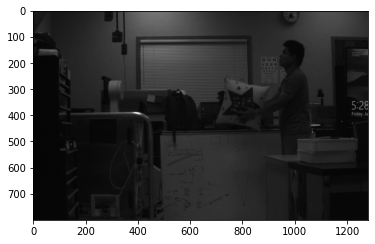

(1088, 1456, 1)

In [3]:
path = 'data/HFR-LFR'
scene = 'pillow_1'
frame_index = 141
img0 = Image.open(f'{path}/{scene}/{frame_index}.png')
img1 = Image.open(f'{path}/{scene}/cam1_4.png')
img2 = Image.open(f'{path}/{scene}/cam2_4.png')
img3 = Image.open(f'{path}/{scene}/cam3_4.png')
img0  = np.array(img0,  dtype=np.float32)[..., np.newaxis]
img0 = (img0/img0.max())**(1/1.6)*255.0
img1 = np.array(img1, dtype=np.float32)[..., np.newaxis]
img2  = np.array(img2,  dtype=np.float32)[..., np.newaxis]
img2 = img2*3./5.
img3 = np.array(img3, dtype=np.float32)[..., np.newaxis]
img3 = img3*8./5. #, 0., 255.)
img_rights = [img1, img2, img3]
plt.imshow(img3[...,0], cmap='gray')
plt.show()
img0.shape

In [4]:
def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255)

x_left = toTensor(img0).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [5]:
net = PAT(1, in_channel=1, num_input=4).to('cuda')
net = nn.DataParallel(net)
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_4inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

<All keys matched successfully>

In [6]:
with torch.no_grad():
    x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [7]:
with torch.no_grad():
    fused_feature = torch.zeros((1, 256, 1088, 1456)).float().to('cuda')
    for i in range(2):
        for j in range(4):
            
            ID = i*4+j+1
            print(ID)
            xl, xu, yl, yu = i*544, i*544+544, j*364, j*364+364
            
            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            for k in range(3):
                xxs = np.load('{}/xxs_{:04d}_{}.npy'.format(path, ID, k+1))[np.newaxis]
                yys = np.load('{}/yys_{:04d}_{}.npy'.format(path, ID, k+1))[np.newaxis]
                Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1)
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

1
2
3
4
5
6
7
8


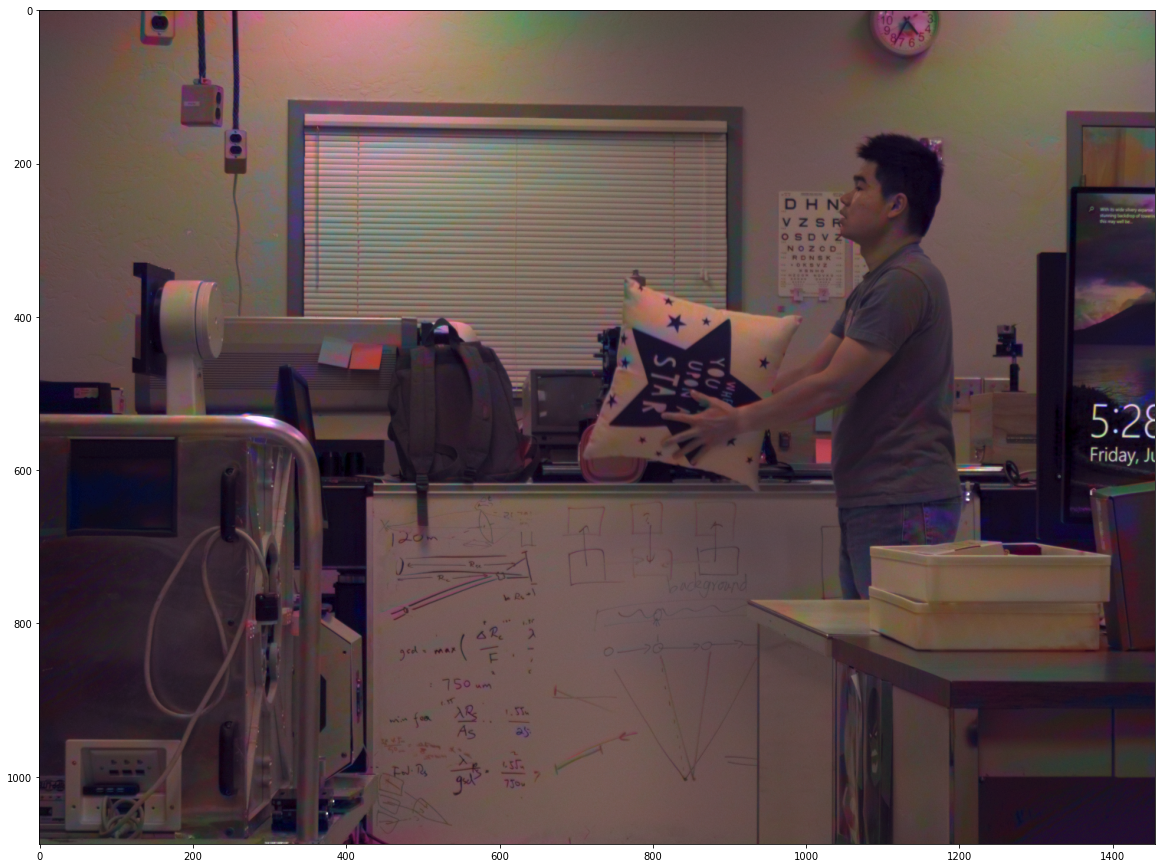

In [8]:
img = torch.clamp(out, 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

<ipython-input-9-43257b2764a9>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fI=inputImage.astype(np.float)


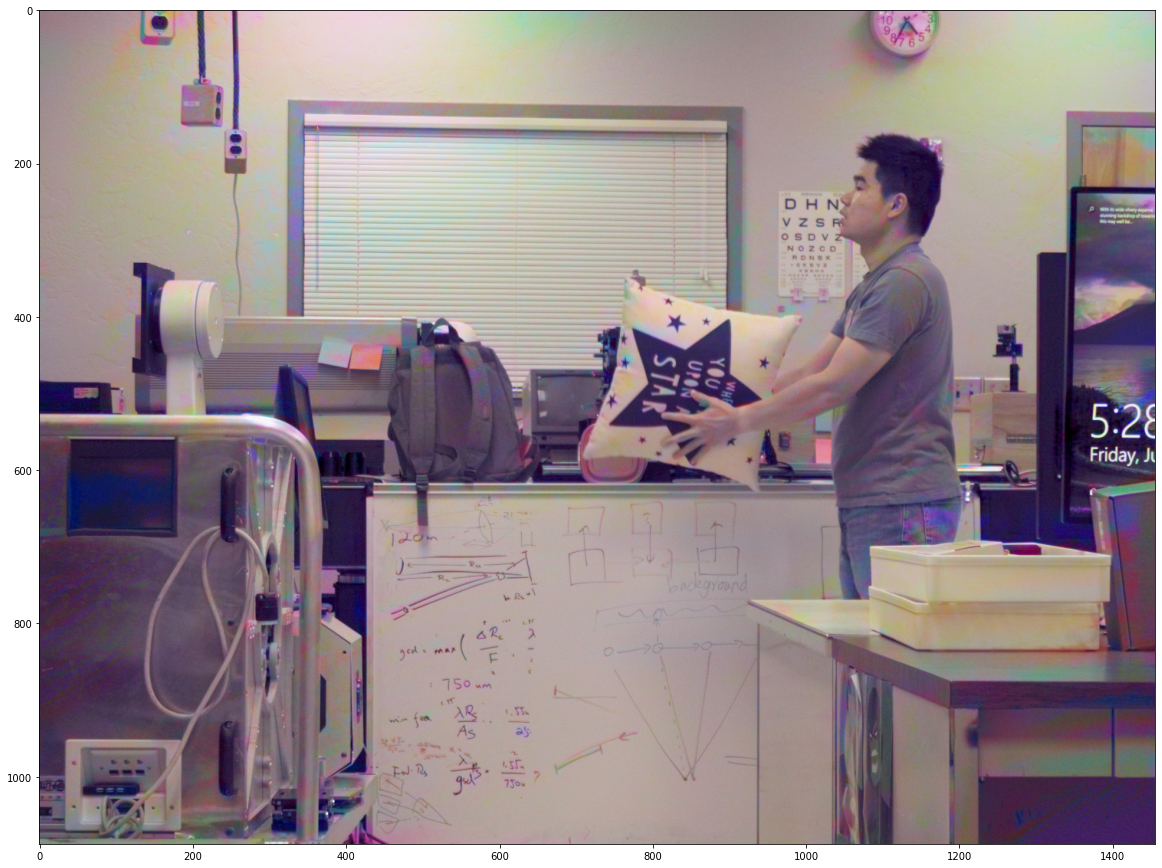

In [9]:
def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,gamma = 0.5, contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]#
    fI=gain*fI/np.max(fI)
    fI = np.power(fI, 1/gamma)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI
img = adjustColor(img, rc = .9, bc = 1, gain = 1.5, gamma = 1, contrast = 1.5)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [10]:
cv2.imwrite(f'results/Jun17pm_{scene}_{frame_index}_asawhole_x4.png', img[..., ::-1])

True